# Unsupervised Learning to Identify Man vs. Zone

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
project_dir = "../data/"

## Loading Data

In [12]:
games = pd.read_csv(f'{project_dir}games.csv')
play_df = pd.read_csv(f'{project_dir}plays.csv')
player_plays = pd.read_csv(f'{project_dir}player_play.csv')
players = pd.read_csv(f'{project_dir}players.csv')
tracking_df = pd.read_csv(f'{project_dir}tracking_week_1.csv')

## Feature Engineering

In [13]:
positions = {
    'oline': ['T', 'G', 'C'],
    'tight_end': ['TE'],
    'receiver': ['WR'],
    'running_back': ['RB', 'FB'],
    'quarterback': ['QB'],
    'dline': ['DT', 'DE', 'NT'],
    'linebacker': ['LB', 'OLB', 'ILB', 'MLB'],
    'cornerback': ['CB'],
    'safety': ['SS', 'FS']
}

players['position_group'] = players['position'].apply(lambda x: next((k for k, v in positions.items() if x in v), None))
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,position_group
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady,quarterback
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters,oline
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers,quarterback
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis,tight_end
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan,quarterback


Add postion groups to tracking data

In [14]:
tracking_df.drop(columns=['displayName', 'frameType','time', 'jerseyNumber', 'club', 'playDirection', 'event'], inplace=True)

# Need to merge players with player_plays to get the position_group
temp = pd.merge(
    players[['nflId', 'position_group']], 
    player_plays[['nflId', 'gameId', 'playId']], 
    on='nflId', 
    how='right'
)

tracking_df = pd.merge(
    tracking_df, 
    temp, 
on=['gameId', 'playId', 'nflId'], 
how='left'
)
tracking_df.head()

,gameId,playId,nflId,frameId,x,y,s,a,dis,o,dir,position_group
0,2022091200,64,35459.0,1,51.06,28.55,0.72,0.37,0.07,246.17,68.34,safety
1,2022091200,64,35459.0,2,51.13,28.57,0.71,0.36,0.07,245.41,71.21,safety
2,2022091200,64,35459.0,3,51.20,28.59,0.69,0.23,0.07,244.45,69.90,safety
3,2022091200,64,35459.0,4,51.26,28.62,0.67,0.22,0.07,244.45,67.98,safety
4,2022091200,64,35459.0,5,51.32,28.65,0.65,0.34,0.07,245.74,62.83,safety


Only keep DBs

In [15]:
dbs = tracking_df[tracking_df['position_group'].isin(['cornerback', 'safety'])].dropna()

Get min and max number of dbs per play

In [16]:
# Count the number of safeties in each frame
db_count = dbs.groupby(['gameId', 'playId', 'frameId', 'position_group'])['nflId'].count()

# To focus on safeties, you can filter the position_group for safeties first:
cb_count = db_count[db_count.index.get_level_values('position_group') == 'cornerback']

s_count = db_count[db_count.index.get_level_values('position_group') == 'safety']

# Find the minimum and maximum number of safeties for each frame
min_cbs = cb_count.min()
max_cbs = cb_count.max()
min_safeties = s_count.min()
max_safeties = s_count.max()

print(f"Minimum number of cornerbacks: {min_cbs}")
print(f"Maximum number of cornerbacks: {max_cbs}")
print(f"Minimum number of safeties: {min_safeties}")
print(f"Maximum number of safeties: {max_safeties}")

Minimum number of cornerbacks: 1
Maximum number of cornerbacks: 4
Minimum number of safeties: 1
Maximum number of safeties: 4


To handle this, we will make each row a frame with all DBs on the play and set all cols with no players to 0

In [17]:
# Sort so all players are aligned on each axis
tracking_df = tracking_df.sort_values(by=['gameId', 'playId', 'position_group', 'x', 'y'])

features = {
    'gameId' : [],
    'playId' : [],
    'frameId' : [],
    'cb1_x': [],
    'cb1_y': [],
    'cb1_s': [],
    'cb1_a': [],
    'cb1_dis': [],
    'cb1_o': [],
    'cb1_dir': [],
    'cb2_x': [],
    'cb2_y': [],
    'cb2_s': [],
    'cb2_a': [],
    'cb2_dis': [],
    'cb2_o': [],
    'cb2_dir': [],
    'cb3_x': [],
    'cb3_y': [],
    'cb3_s': [],
    'cb3_a': [],
    'cb3_dis': [],
    'cb3_o': [],
    'cb3_dir': [],
    'cb4_x': [],
    'cb4_y': [],
    'cb4_s': [],
    'cb4_a': [],
    'cb4_dis': [],
    'cb4_o': [],
    'cb4_dir': [],
    's1_x': [],
    's1_y': [],
    's1_s': [],
    's1_a': [],
    's1_dis': [],
    's1_o': [],
    's1_dir': [],
    's2_x': [],
    's2_y': [],
    's2_s': [],
    's2_a': [],
    's2_dis': [],
    's2_o': [],
    's2_dir': [],
    's3_x': [],
    's3_y': [],
    's3_s': [],
    's3_a': [],
    's3_dis': [],
    's3_o': [],
    's3_dir': [],
    's4_x': [],
    's4_y': [],
    's4_s': [],
    's4_a': [],
    's4_dis': [],
    's4_o': [],
    's4_dir': []
}
for (game_id, play_id, frame_id), group in tracking_df.groupby(['gameId', 'playId', 'frameId']):
    corners = group[group['position_group'] == 'cornerback']
    safeties = group[group['position_group'] == 'safety']

    for i in range(1, 5):
        if i <= len(corners):
            corner = corners.iloc[i-1]
            features[f'cb{i}_x'].append(corner['x'])
            features[f'cb{i}_y'].append(corner['y'])
            features[f'cb{i}_s'].append(corner['s'])
            features[f'cb{i}_a'].append(corner['a'])
            features[f'cb{i}_dis'].append(corner['dis'])
            features[f'cb{i}_o'].append(corner['o'])
            features[f'cb{i}_dir'].append(corner['dir'])
        else:
            features[f'cb{i}_x'].append(0)
            features[f'cb{i}_y'].append(0)
            features[f'cb{i}_s'].append(0)
            features[f'cb{i}_a'].append(0)
            features[f'cb{i}_dis'].append(0)
            features[f'cb{i}_o'].append(0)
            features[f'cb{i}_dir'].append(0)
    
    for i in range(1, 5):
        if i <= len(safeties):
            safety = safeties.iloc[i-1]
            features[f's{i}_x'].append(safety['x'])
            features[f's{i}_y'].append(safety['y'])
            features[f's{i}_s'].append(safety['s'])
            features[f's{i}_a'].append(safety['a'])
            features[f's{i}_dis'].append(safety['dis'])
            features[f's{i}_o'].append(safety['o'])
            features[f's{i}_dir'].append(safety['dir'])
        else:
            features[f's{i}_x'].append(0)
            features[f's{i}_y'].append(0)
            features[f's{i}_s'].append(0)
            features[f's{i}_a'].append(0)
            features[f's{i}_dis'].append(0)
            features[f's{i}_o'].append(0)
            features[f's{i}_dir'].append(0)

    features['gameId'].append(game_id)
    features['playId'].append(play_id)
    features['frameId'].append(frame_id)

features_df = pd.DataFrame(features)

Dropping ID columns

In [18]:
features_df.head()
features = features_df.drop(columns=['gameId', 'playId', 'frameId'])

## Determining Cluster Count

### WSS

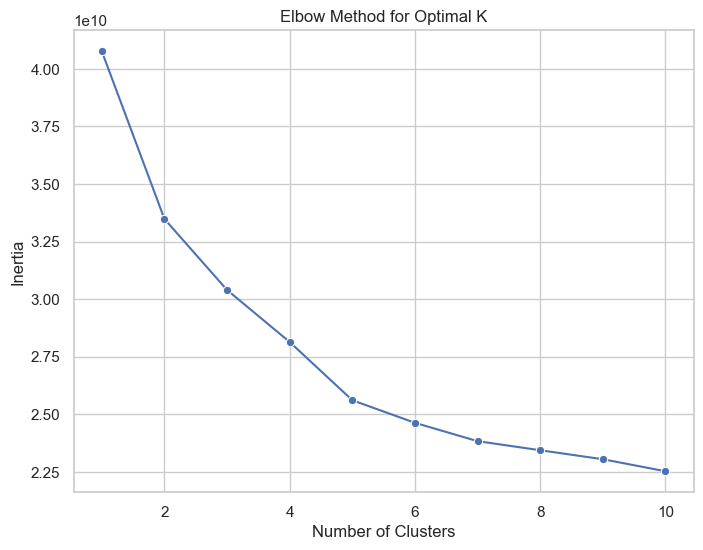

In [19]:
# Assuming X is your feature matrix
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, 11), y=inertia, marker="o", color='b')

plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Silhouette

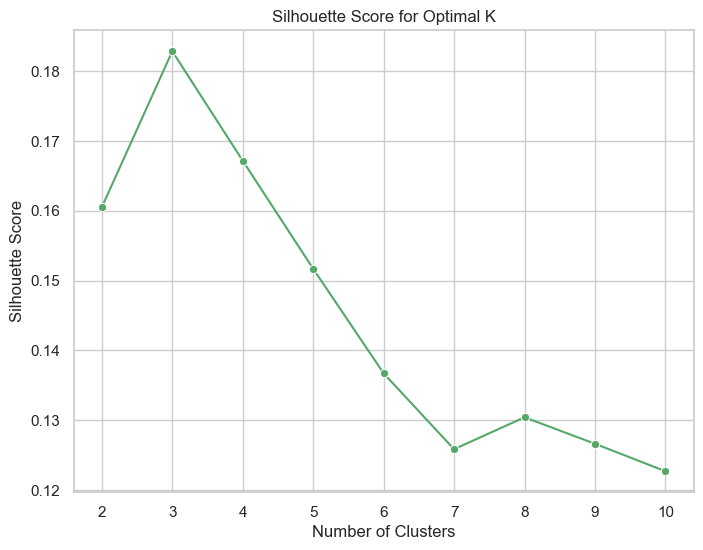

In [20]:
# To speed up the process, we can sample a subset of the data
sampled_df = features.sample(frac=0.2, random_state=42)

sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sampled_df)
    sil_score = silhouette_score(sampled_df, kmeans.labels_)
    sil_scores.append(sil_score)

# Create a Seaborn line plot for the Silhouette Method
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(2, 11), y=sil_scores, marker="o", color='g')

plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Gap Stat

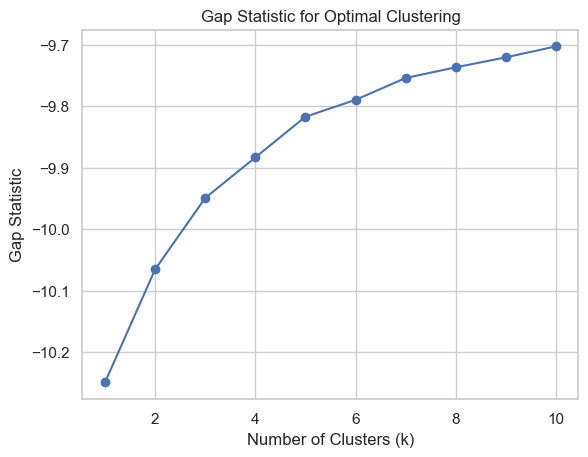

Optimal number of clusters: 10


In [ ]:
def gap_statistic(X, max_k=10, n_ref=10):
    """
    Calculate the Gap Statistic for a dataset X for a range of k values.
    
    Parameters:
    - X: The input data, shape (n_samples, n_features)
    - max_k: Maximum number of clusters to evaluate
    - n_ref: Number of reference datasets (random distributions)
    
    Returns:
    - gap_values: A list of gap statistic values for each k
    - k_values: A list of k values corresponding to the gap statistics
    """
    def calculate_dispersion(X, k):
        """Calculate within-cluster dispersion (sum of squared distances to centroids)"""
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        dispersion = 0
        for i in range(k):
            points_in_cluster = X[labels == i]
            dispersion += np.sum(np.linalg.norm(points_in_cluster - centers[i], axis=1) ** 2)
        return dispersion
    
    gap_values = []
    for k in range(1, max_k + 1):
        # Calculate W_k for the original data
        W_k = calculate_dispersion(X, k)
        
        # Calculate W_k* for reference data (uniform random distribution)
        W_k_star = 0
        for _ in range(n_ref):
            # Generate a random dataset
            random_data = np.random.rand(*X.shape)
            W_k_star += calculate_dispersion(random_data, k)
        
        # Calculate Gap Statistic
        gap = np.log(W_k_star / n_ref) - np.log(W_k)
        gap_values.append(gap)
    
    return gap_values, list(range(1, max_k + 1))

# Sample a subset of the data
sampled_df = features.sample(frac=0.15, random_state=42)

gap_values, k_values = gap_statistic(sampled_df, max_k=10, n_ref=10)

# Plotting
plt.plot(k_values, gap_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic for Optimal Clustering')
plt.show()

# Find optimal k
optimal_k = k_values[np.argmax(gap_values)]
print(f"Optimal number of clusters: {optimal_k}")


From our WSS plot, the elbow is at approx. $k=5$ and from our silhouette plot, we see that $k=2$ produces the max silhouette score. We will therefore experiment with values of $k$ between 2 and 5.

## Clustering

In [27]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features)
labels = kmeans.labels_

Plotting using first 2 PCs

/Users/nolanbirkeland/Desktop/big_data_bowl/python/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


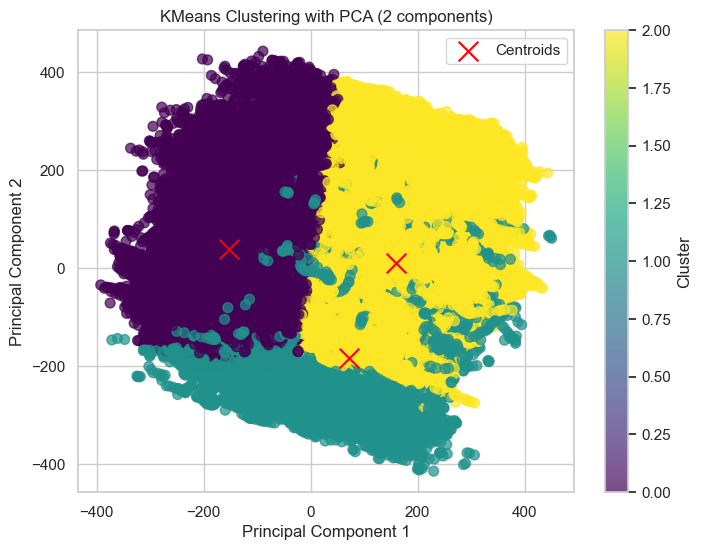

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Plot the first two PCs, colored by the cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('KMeans Clustering with PCA (2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot the cluster centers in PCA space
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label='Centroids')
plt.legend()

plt.show()

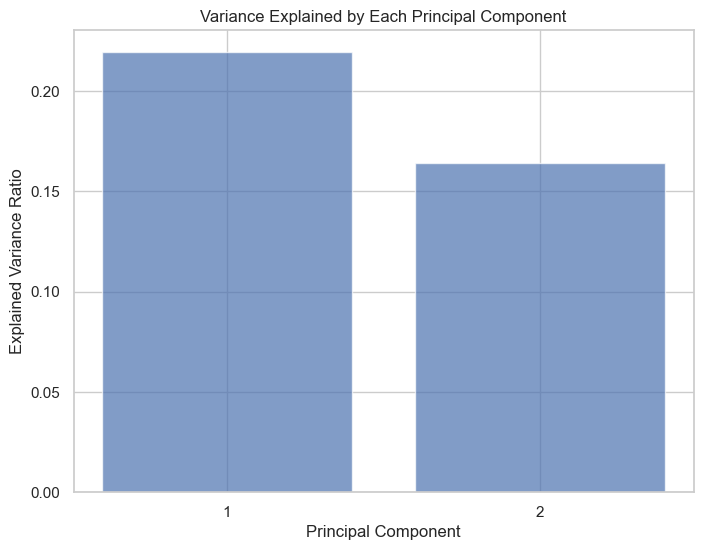

Explained Variance Ratio for each PC:
PC1: 0.22 (21.93%)
PC2: 0.16 (16.43%)


In [34]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Display variance explained by each principal component
print("Explained Variance Ratio for each PC:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var_ratio:.2f} ({var_ratio*100:.2f}%)")

## Assigning Clusters to PFF Coverages

In [ ]:
features_df['cluster'] = labels

# joining with pff data
results = pd.merge(features_df, play_df[['gameId', 'playId', 'pff_passCoverage', 'pff_manZone']], on=['gameId', 'playId'], how='left')

results = results.dropna()
print(results['cluster'].value_counts())
print(results['pff_manZone'].value_counts())

cluster
0    146538
2    122314
1     38515
Name: count, dtype: int64
pff_manZone
Zone     222840
Man       68242
Other     16285
Name: count, dtype: int64


In [55]:
# correlation between manZone and cluster
manzone = results['pff_manZone'].map({
    "Zone" : 0,
    "Man": 1,
    "Other": 2
})

correlation = pd.DataFrame({'manzone': manzone, 'cluster': results['cluster']}).corr()

# Print the correlation
print(correlation)

          manzone   cluster
manzone  1.000000 -0.002107
cluster -0.002107  1.000000


Unfortunately pretty weak results. 

Need to experiment with more clusters and investigate what the actual cluster results show